In [1]:

from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif,  RFECV, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier,  RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,cohen_kappa_score 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
import pandas as pd
import pickle
from feature_engine.selection import SelectByTargetMeanPerformance


In [2]:
#mapping category:name
cat_mapping = { 'category1' : 'aesthetics',
                'category2' : 'uniqueness', 
                'category3' : 'minimalism',
                'category4' : 'innovation',
                'category5' : 'usability',
                'category6' : 'elegance' }

In [3]:
# Function to calculate Wilson Score Interval (returns values in range 0-1)
def wilson_score_positive_ratings(pos, total, confidence=0.95):
    if total == 0:
        return 0

    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    phat = pos / total
    score = (phat + z*z/(2*total) - z * (phat*(1-phat) + z*z/(4*total))/total) / (1 + z*z/total)
    return score

In [5]:
# Read Ratings DataFrame from Pickle file (initial data or with additional prolific data)
df_ratings = pd.read_pickle('df_ratings_prolific2rounds.pkl')
# Remove .png from bid column
df_ratings['bid'] = df_ratings['bid'].str.replace('.png', '')
# Read Regstrations DataFrame from Pickle file
df_registrations = pd.read_pickle('df_registrations.pkl')
#Load biked dataset (visual reduced)
BIKED_df_visual_reduced = pd.read_csv("clip_sBIKED_reduced.csv", index_col=0)
print("visual reduced shape with all bikes", BIKED_df_visual_reduced.shape)
# extract bike names -> these row need to be retrieved from BIKED
unique_bike_names =  df_ratings['bid'].unique()
# Filter out empty string and convert bike names to integers
numeric_integers = [int(x) for x in unique_bike_names if x != '']
#eliminate those bikes that are not in ds -> delete when 50 bikes
bikes_to_remove = [2478, 3229, 3099, 2362, 2998, 2365, 2880]
bikes_43 = [item for item in numeric_integers if item not in bikes_to_remove]
# take only 43 relevant BIKED rows from visual reduced 
BIKED_selected_df_reduced = BIKED_df_visual_reduced.loc[bikes_43]
print("visual reduced shape with only bikes of interest", BIKED_selected_df_reduced.shape)

#check dtypes
dtypes = BIKED_selected_df_reduced.dtypes.unique().tolist()
#print(dtypes)
#check how many features per dtype
numerical_features = BIKED_selected_df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(len(numerical_features), "numerical (int/float)")

categorical_features = BIKED_selected_df_reduced.select_dtypes(include=['O']).columns
print(len(categorical_features.tolist()), "categorical", categorical_features.tolist())
#check how many values each can take
for cf in categorical_features.tolist():
    print(cf, "can take", BIKED_selected_df_reduced[cf].nunique(), "values")


bool_features = BIKED_selected_df_reduced.select_dtypes(include=['bool']).columns
print(len(bool_features.tolist()), "boolean")

visual reduced shape with all bikes (4512, 71)
visual reduced shape with only bikes of interest (43, 71)
60 numerical (int/float)
3 categorical ['MATERIAL', 'RIM_STYLE front', 'RIM_STYLE rear']
MATERIAL can take 6 values
RIM_STYLE front can take 3 values
RIM_STYLE rear can take 3 values
8 boolean


In [5]:
#WORK ON RATINGS 
#remove empty doc from ratings (needed to start collection in firestore
df_ratings = df_ratings[df_ratings['bid'] != ""].reset_index(drop=True)
# Convert 'bid' column to integers and removE ratings of the 7 missing bikes 
df_ratings = df_ratings[~df_ratings['bid'].astype(int).isin(bikes_to_remove)].reset_index(drop=True)
#from (4696, 4) to (4056, 4) - 43 bikes remaining!

#check how many users rated each catgory
category_user_counts = df_ratings.groupby('cat')['uid'].nunique().reset_index()
#print(category_user_counts)

#check how many ratings in total per category
category_ratings_counts = df_ratings.groupby('cat')['rat'].count().reset_index()
print("ratings per category \n", category_ratings_counts)

ratings per category 
          cat   rat
0  category1  1159
1  category2   916
2  category3   876
3  category4   881
4  category5  1013
5  category6   893


In [6]:
#FLEISS KAPPA (INTER ANNOTATOR AGREEMENT)
# Adapted from https://gist.github.com/ShinNoNoir/4749548
def fleiss_kappa2(ratings, n):
    '''
    Computes the Fleiss' kappa measure for assessing the reliability of 
    agreement between a fixed number n of raters when assigning categorical
    ratings to a number of items.
    
    Args:
        ratings: a list of (item, category)-ratings
        n: number of raters
        k: number of categories
    Returns:
        the Fleiss' kappa score
    
    See also:
        http://en.wikipedia.org/wiki/Fleiss'_kappa
    '''
    items = set()
    categories = set()
    n_ij = {}
    
    for i, c in ratings:
        items.add(i)
        categories.add(c)
        n_ij[(i,c)] = n_ij.get((i,c), 0) + 1
    
    N = len(items)
    
    p_j = dict(((c, sum(n_ij.get((i, c), 0) for i in items) / (1.0 * n * N)) for c in categories))
    P_i = dict(((i, (sum(n_ij.get((i, c), 0) ** 2 for c in categories) - n) / (n * (n - 1.0))) for i in items))

    P_bar = sum(P_i.values()) / (1.0 * N)
    P_e_bar = sum(value ** 2 for value in p_j.values())
    
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    
    return kappa



In [7]:
#use flieskappa2
unique_categories =  df_ratings['cat'].unique()

for category in unique_categories:
    print(cat_mapping[category])
    # Filter data for the current category
    category_df = df_ratings[df_ratings['cat'] == category]
    # Pivot the table to get a matrix of ratings (each row is a bike, each column an annotator)
    ratings_matrix = category_df.pivot_table(index='bid', columns='uid', values='rat', fill_value=False).astype(int).values
    # Initialize the table of counts
    table_of_counts = []

    # Iterate through each row of the matrix
    for row_number, row in enumerate(ratings_matrix):
        # Count the number of 0s and 1s in the row
        count_0 = np.count_nonzero(row == 0)
        count_1 = np.count_nonzero(row == 1)
        
        # Append the counts to the table
        table_of_counts.append([row_number, count_0, count_1])

    # Initialize the ratings list
    ratings = []

    # Iterate through each row of the table
    for row in table_of_counts:
        row_number, count_0, count_1 = row
        ratings.extend([(row_number, 'yes')] * count_1 + [(row_number, 'no')] * count_0) 
    print(fleiss_kappa2(ratings, count_1+count_0))
    

minimalism
0.015282795972103132
elegance
0.014664475640837709
aesthetics


C:\Users\vital\AppData\Local\Temp\ipykernel_9112\788836915.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ratings_matrix = category_df.pivot_table(index='bid', columns='uid', values='rat', fill_value=False).astype(int).values
C:\Users\vital\AppData\Local\Temp\ipykernel_9112\788836915.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ratings_matrix = category_df.pivot_table(index='bid', columns='uid', values='rat', fill_value=False).astype(int).values
C:\Users\vital\AppData\Local\Temp\ipykernel_9112\788836915.py:9: FutureWarning: Downcasting object

0.00956368967190671
usability
0.024197215258304133
innovation
0.0014823064496291322
uniqueness
0.010372160460199878


C:\Users\vital\AppData\Local\Temp\ipykernel_9112\788836915.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ratings_matrix = category_df.pivot_table(index='bid', columns='uid', values='rat', fill_value=False).astype(int).values
C:\Users\vital\AppData\Local\Temp\ipykernel_9112\788836915.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ratings_matrix = category_df.pivot_table(index='bid', columns='uid', values='rat', fill_value=False).astype(int).values


In [8]:

# Create an empty dictionary to store all ratings for each category
category_dfs = {}
# Iterate over unique categories and create a DataFrame for each
unique_users =  df_ratings['uid'].unique()
unique_cat_names = [cat_mapping[category] for category in unique_categories]
#print("number of users", len(unique_users))
for category in unique_categories:
    category_df = df_ratings[df_ratings['cat'] == category].copy()
    # Drop the 'cat' and 'uid' column
    category_df.drop(columns=['cat'], inplace=True)
    category_df.drop(columns=['uid'], inplace=True)
    #add to dict
    category_dfs[category] = category_df


In [9]:


wilson_df = BIKED_selected_df_reduced.copy()
binary_df = BIKED_selected_df_reduced.copy()

#loop through each category df 
for c_name, c_count in category_dfs.items():
    # Convert 'rat' column to 1 for True, 0 for False
    c_count['rat'] = c_count['rat'].astype(int)
    # Group by 'bid' and aggregate counts
    count_df = c_count.groupby('bid').agg({
        'rat': ['sum', 'count']
    }).reset_index()
    # Rename columns
    count_df.columns = ['bid', 'true_count', 'total_count']
    count_df.set_index('bid', inplace=True)
   
    # Calculate 'false_count' as the difference between 'total_count' and 'true_count'
    count_df['false_count'] = count_df['total_count'] - count_df['true_count']
    # Calculate a normalized score
    count_df['success_rate'] = (count_df['true_count'] - count_df['false_count']) / (count_df['true_count'] + count_df['false_count'])
    #calculate Wilson Interval Score for each row
    count_df['wilson_score'] = count_df.apply(lambda row: wilson_score_positive_ratings(row['true_count'], row['total_count']), axis=1)
    #calculate Binary Score column (threshold = 0.5)
    median_score = count_df['wilson_score'].median()
    # Calculate Binary Score column using median as threshold
    count_df['binary_score'] = (count_df['wilson_score'] >= median_score).astype(int)
    count_df.index = count_df.index.astype(int)
    
    #add computed scores per each category to wilson/binary df -> now 77 columns
    cat_str = str(cat_mapping[c_name]) 
    wilson_df.loc[count_df.index, cat_str + '_wilson'] = count_df['wilson_score']
    binary_df.loc[count_df.index, cat_str + '_binary'] = count_df['binary_score']

In [109]:
binary_df.head()

,CS textfield,BB textfield,Stack,Head angle,Head tube length textfield,Seat stay junction0,Seat tube length,Seat angle,DT Length,BB diameter,...,Saddle length,Saddle height,Down tube diameter,Seatpost LENGTH,minimalism_binary,elegance_binary,aesthetics_binary,usability_binary,innovation_binary,uniqueness_binary
1218,405.0,6.0,565.6,73.0,137.9,45.0,500.0,74.0,585.431904,40.0,...,210.0,718.0,34.9,300.0,1.0,0.0,0.0,0.0,1.0,1.0
240,600.0,-302.5,565.6,77.0,60.0,37.0,0.0,68.1,293.734768,38.1,...,290.0,610.0,14.0,130.0,1.0,1.0,1.0,0.0,0.0,1.0
1039,800.0,0.0,565.6,45.0,315.3,45.0,425.0,75.0,522.010593,40.0,...,278.0,625.0,34.9,300.0,0.0,0.0,0.0,0.0,0.0,1.0
1244,350.0,0.0,565.6,75.0,179.1,44.0,350.0,74.0,591.584055,40.0,...,278.0,718.0,34.9,150.0,0.0,0.0,0.0,1.0,0.0,0.0
678,405.0,70.0,565.6,73.0,145.0,45.0,544.4,74.0,626.144585,80.0,...,278.0,718.0,34.9,300.0,0.0,1.0,0.0,1.0,1.0,1.0


CHECK CLASS DISTRIBUTION AFTER BINARIZATION

In [10]:
for c in unique_cat_names:
    #print(c)
    zeros = binary_df[c + '_binary'].value_counts()[0]
    ones = binary_df[c + '_binary'].value_counts()[1]
    #print("zeros:", zeros)
    #print("ones:", ones)


In [11]:
feature_df = wilson_df.iloc[:, :71]
# Fill NaN values with the mean of the respective columns 
feature_df = feature_df.fillna(feature_df['Stack'].mean())

#One-hot encode categorical features 
#we will have 12 new columns (hot-enc) - 3 (cat) that will get dropped = 9 more
#why 12 new? cause categ var take 3,3 and 6 values respectively
feature_df = pd.get_dummies(feature_df, drop_first=True)
'''
enc = LabelEncoder()
for c in categorical_features.tolist():
    feature_df[c] = enc.fit_transform(feature_df[c])
'''
# Convert all boolean features to int
boolean_features = feature_df.select_dtypes(include=['bool']).columns
feature_df[boolean_features] = feature_df[boolean_features].astype(int)
#print(feature_df)

In [97]:
feature_df.shape

(43, 74)

PLOT FEATURES DISTRIBUTION

In [46]:
'''
# Create a grid of subplots
num_rows = 20  # Number of rows in the grid
num_cols = 4   # Number of columns in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature and plot its distribution
for i, feat in enumerate(feature_df.columns):
    ax = axes[i]  # Select the current subplot
    feature_df[feat].plot(kind='hist', bins=10, ax=ax)  # Plot histogram for the current feature
    ax.set_title(f'Distribution of {feat}')  # Set title
    ax.set_xlabel(feat)  # Set x-axis label
    ax.set_ylabel('Frequency')  # Set y-axis label
    ax.grid(True)  # Show grid

# Hide any extra subplots
for i in range(len(feature_df.columns), num_rows*num_cols):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
'''

"\n# Create a grid of subplots\nnum_rows = 20  # Number of rows in the grid\nnum_cols = 4   # Number of columns in the grid\nfig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))  # Adjust figsize as needed\n\n# Flatten the axes array for easy iteration\naxes = axes.flatten()\n\n# Iterate over each feature and plot its distribution\nfor i, feat in enumerate(feature_df.columns):\n    ax = axes[i]  # Select the current subplot\n    feature_df[feat].plot(kind='hist', bins=10, ax=ax)  # Plot histogram for the current feature\n    ax.set_title(f'Distribution of {feat}')  # Set title\n    ax.set_xlabel(feat)  # Set x-axis label\n    ax.set_ylabel('Frequency')  # Set y-axis label\n    ax.grid(True)  # Show grid\n\n# Hide any extra subplots\nfor i in range(len(feature_df.columns), num_rows*num_cols):\n    axes[i].axis('off')\n\n# Adjust layout\nplt.tight_layout()\n\n# Show plot\nplt.show()\n"

PLOT EACH FEATURE VS BINARY SCORE

In [47]:
'''
for c in unique_cat_names:
    print(c)
    # Create a grid of subplots
    num_rows = 20  # Number of rows in the grid
    num_cols = 4   # Number of columns in the grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))  # Adjust figsize as needed

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each feature and plot its scatter plot against the binary target variable
    for i, feat in enumerate(feature_df.columns):
        ax = axes[i]  # Select the current subplot
        sns.scatterplot(x=feature_df[feat], y=binary_df[c+'_binary'], hue=binary_df[c+'_binary'], ax=ax, palette='Set1')  # Plot scatter plot for the current feature
        ax.set_title(f'{feat} vs Binary Target')  # Set title
        ax.set_xlabel(feat)  # Set x-axis label
        ax.set_ylabel('Binary Target')  # Set y-axis label
        ax.grid(True)  # Show grid
        ax.legend(title='Binary Target', loc='upper right')  # Add legend

    # Hide any extra subplots
    for i in range(len(feature_df.columns), num_rows*num_cols):
        axes[i].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()
'''


"\nfor c in unique_cat_names:\n    print(c)\n    # Create a grid of subplots\n    num_rows = 20  # Number of rows in the grid\n    num_cols = 4   # Number of columns in the grid\n    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))  # Adjust figsize as needed\n\n    # Flatten the axes array for easy iteration\n    axes = axes.flatten()\n\n    # Iterate over each feature and plot its scatter plot against the binary target variable\n    for i, feat in enumerate(feature_df.columns):\n        ax = axes[i]  # Select the current subplot\n        sns.scatterplot(x=feature_df[feat], y=binary_df[c+'_binary'], hue=binary_df[c+'_binary'], ax=ax, palette='Set1')  # Plot scatter plot for the current feature\n        ax.set_title(f'{feat} vs Binary Target')  # Set title\n        ax.set_xlabel(feat)  # Set x-axis label\n        ax.set_ylabel('Binary Target')  # Set y-axis label\n        ax.grid(True)  # Show grid\n        ax.legend(title='Binary Target', loc='upper right')  # Add legend

PLOT EACH FEATURE VS WILSON SCORE

In [48]:
'''
for c in unique_cat_names:
    print(c)
    # Create a grid of subplots
    num_rows = 20  # Number of rows in the grid
    num_cols = 4   # Number of columns in the grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))  # Adjust figsize as needed

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each feature and plot its scatter plot against the target variable
    for i, feat in enumerate(feature_df.columns):
        ax = axes[i]  # Select the current subplot
        sns.scatterplot(x=feature_df[feat], y=wilson_df[c+ '_wilson'], ax=ax)  # Plot scatter plot for the current feature
        ax.set_title(f'{feat} vs Target')  # Set title
        ax.set_xlabel(feat)  # Set x-axis label
        ax.set_ylabel('Target')  # Set y-axis label
        ax.grid(True)  # Show grid

    # Hide any extra subplots
    for i in range(len(feature_df.columns), num_rows*num_cols):
        axes[i].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()
'''

"\nfor c in unique_cat_names:\n    print(c)\n    # Create a grid of subplots\n    num_rows = 20  # Number of rows in the grid\n    num_cols = 4   # Number of columns in the grid\n    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))  # Adjust figsize as needed\n\n    # Flatten the axes array for easy iteration\n    axes = axes.flatten()\n\n    # Iterate over each feature and plot its scatter plot against the target variable\n    for i, feat in enumerate(feature_df.columns):\n        ax = axes[i]  # Select the current subplot\n        sns.scatterplot(x=feature_df[feat], y=wilson_df[c+ '_wilson'], ax=ax)  # Plot scatter plot for the current feature\n        ax.set_title(f'{feat} vs Target')  # Set title\n        ax.set_xlabel(feat)  # Set x-axis label\n        ax.set_ylabel('Target')  # Set y-axis label\n        ax.grid(True)  # Show grid\n\n    # Hide any extra subplots\n    for i in range(len(feature_df.columns), num_rows*num_cols):\n        axes[i].axis('off')\n\n    # Ad

In [15]:

#scale data
# Scale data
scaler = preprocessing.StandardScaler().fit(feature_df)
X_scaled = scaler.transform(feature_df)
# Convert scaled array back to DataFrame with the same indexes
X = pd.DataFrame(data=X_scaled, columns=feature_df.columns, index=feature_df.index)



CHECK REGRESSION WITH ALL FEATURES (linear regresison, lasso, lasso cv)

In [16]:

# Define the number of folds for cross-validation
n_folds = 5 
# Initialize KFold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42) 

LASSO (WILSON)

In [17]:
for c in unique_cat_names:
    print(c)
    y = wilson_df[c + '_wilson']
    ################################
    reg = LinearRegression().fit(X, y)
    print("linear regression no cv r2:", reg.score(X, y))

    ################################
    reg = Lasso().fit(X, y)
    print("lasso no cv r2:", reg.score(X, y))

    #######################################
    # Initialize Lasso regression model
    reg = Lasso()
    # Perform cross-validation for R2
    cv_scores_r2 = cross_val_score(reg, X, y, cv=kf, scoring='r2')
    average_r2 = np.mean(cv_scores_r2)
    print("Average R-squared score:", average_r2)

    # Perform cross-validation for MSE
    cv_scores_mse = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_squared_error')
    average_mse = -np.mean(cv_scores_mse)
    print("Average MSE:", average_mse)
    print("\n")


minimalism
linear regression no cv r2: 1.0
lasso no cv r2: 0.0
Average R-squared score: -0.05128889047069909
Average MSE: 0.023095426491427772


elegance
linear regression no cv r2: 1.0
lasso no cv r2: 0.0
Average R-squared score: -0.543982062896488
Average MSE: 0.019320696843726434


aesthetics
linear regression no cv r2: 1.0
lasso no cv r2: 0.0
Average R-squared score: -0.2800058231974548
Average MSE: 0.02287737888252131


usability
linear regression no cv r2: 1.0
lasso no cv r2: 0.0
Average R-squared score: -0.19346961901341006
Average MSE: 0.03406320219196533


innovation
linear regression no cv r2: 1.0
lasso no cv r2: 0.0
Average R-squared score: -0.044754340743237496
Average MSE: 0.011269126019663296


uniqueness
linear regression no cv r2: 1.0
lasso no cv r2: 0.0
Average R-squared score: -0.021580158993762356
Average MSE: 0.03061871726301646




Best hyperparameters for Random Forest

In [18]:
params = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

In [19]:

# Define the Random Forest regressor
rf_regressor = RandomForestRegressor(**params)
for c in unique_cat_names:
    print(c)
    X = feature_df
    y = wilson_df[c + '_wilson']

    ################################
    reg = RandomForestRegressor(**params).fit(X, y)
    print("score rf no cv", reg.score(X, y))

    # Perform cross-validation
    cv_scores = cross_val_score(rf_regressor, X, y, cv=5, scoring='r2')
    # Compute the average R-squared score
    average_r2 = np.mean(cv_scores)
    print("Average R-squared score:", average_r2)

    # Compute cross-validated MSE
    cv_mse_scores = cross_val_score(rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    average_mse = -np.mean(cv_mse_scores)
    print("Average MSE:", average_mse)
    print("\n")


minimalism
score rf no cv 0.872166650722914
Average R-squared score: -0.14830467132595393
Average MSE: 0.0207287865400142


elegance
score rf no cv 0.849783513405374
Average R-squared score: -0.039128072935839864
Average MSE: 0.01871762280351147


aesthetics
score rf no cv 0.8970637142831906
Average R-squared score: 0.05745179306722499
Average MSE: 0.017469470917497714


usability
score rf no cv 0.8933244597369787
Average R-squared score: 0.2003115197215249
Average MSE: 0.023483012577461927


innovation
score rf no cv 0.8731032668738252
Average R-squared score: -0.5823517334583671
Average MSE: 0.012883121630289493


uniqueness
score rf no cv 0.8627905392867019
Average R-squared score: 0.02592732256591117
Average MSE: 0.027507334415236208




CHECK WITH BINARY TARGET

In [20]:
# Define the number of folds for cross-validation
n_folds = 5  # Adjust as needed

for c in unique_cat_names:
    print(c)

    y = binary_df[c + '_binary']

    ################################
    reg = LogisticRegression(max_iter=10000).fit(X, y)
    print("score logistic regression no cv no penalty:", reg.score(X, y))

    ################################
    reg = LogisticRegression(penalty='l1',  solver='saga', max_iter=10000).fit(X, y)
    print("score logistic regression no cv yes penalty:", reg.score(X, y))

    ########################################
    reg = LogisticRegression(penalty='l1',  solver='saga', max_iter=10000)

    # Perform cross-validation
    cv_acc_scores = cross_val_score(reg, X, y, cv=kf, scoring='accuracy')
    cv_f1_scores = cross_val_score(reg, X, y, cv=kf, scoring='f1')

    # Compute overall accuracy and F1 score
    overall_acc = np.mean(cv_acc_scores)
    overall_f1_score = np.mean(cv_f1_scores)

    print("logreg with cv + penalty average accuracy:", overall_acc)
    print("logreg with cv + penalty average f1 score:", overall_f1_score)
    print("\n")


minimalism
score logistic regression no cv no penalty: 1.0
score logistic regression no cv yes penalty: 0.9534883720930233
logreg with cv + penalty average accuracy: 0.5333333333333334
logreg with cv + penalty average f1 score: 0.629090909090909


elegance
score logistic regression no cv no penalty: 1.0
score logistic regression no cv yes penalty: 0.8604651162790697
logreg with cv + penalty average accuracy: 0.4888888888888888
logreg with cv + penalty average f1 score: 0.5364102564102564


aesthetics
score logistic regression no cv no penalty: 1.0
score logistic regression no cv yes penalty: 0.9534883720930233
logreg with cv + penalty average accuracy: 0.6722222222222223
logreg with cv + penalty average f1 score: 0.6987878787878788


usability
score logistic regression no cv no penalty: 1.0
score logistic regression no cv yes penalty: 0.9534883720930233
logreg with cv + penalty average accuracy: 0.5611111111111111
logreg with cv + penalty average f1 score: 0.5890909090909091


innovati

In [21]:


# Define the Random Forest regressor
rf_class = RandomForestClassifier(**params)

for c in unique_cat_names:
    print(c)
    y = binary_df[c + '_binary']

    ################################
    rf = RandomForestClassifier(**params).fit(X, y)
    print("score rf no cv", rf.score(X, y))

    # Perform cross-validation
    cv_scores = cross_val_score(rf_class, X, y, cv=5, scoring='accuracy')
    # Compute the average R-squared score
    average_acc = np.mean(cv_scores)
    print("Average accuracy score:", average_acc)

    # Compute F1 score
    cv_f1_scores = cross_val_score(rf_class, X, y, cv=5, scoring='f1')
    # Compute the average F1 score
    average_f1 = np.mean(cv_f1_scores)
    print("Average F1 score:", average_f1)


minimalism


score rf no cv 1.0
Average accuracy score: 0.5555555555555556
Average F1 score: 0.7102097902097902
elegance
score rf no cv 1.0
Average accuracy score: 0.6055555555555555
Average F1 score: 0.5593650793650793
aesthetics
score rf no cv 1.0
Average accuracy score: 0.6055555555555555
Average F1 score: 0.6286291486291486
usability
score rf no cv 1.0
Average accuracy score: 0.625
Average F1 score: 0.6615873015873015
innovation
score rf no cv 1.0
Average accuracy score: 0.5305555555555556
Average F1 score: 0.6709090909090909
uniqueness
score rf no cv 1.0
Average accuracy score: 0.6277777777777778
Average F1 score: 0.4609523809523809


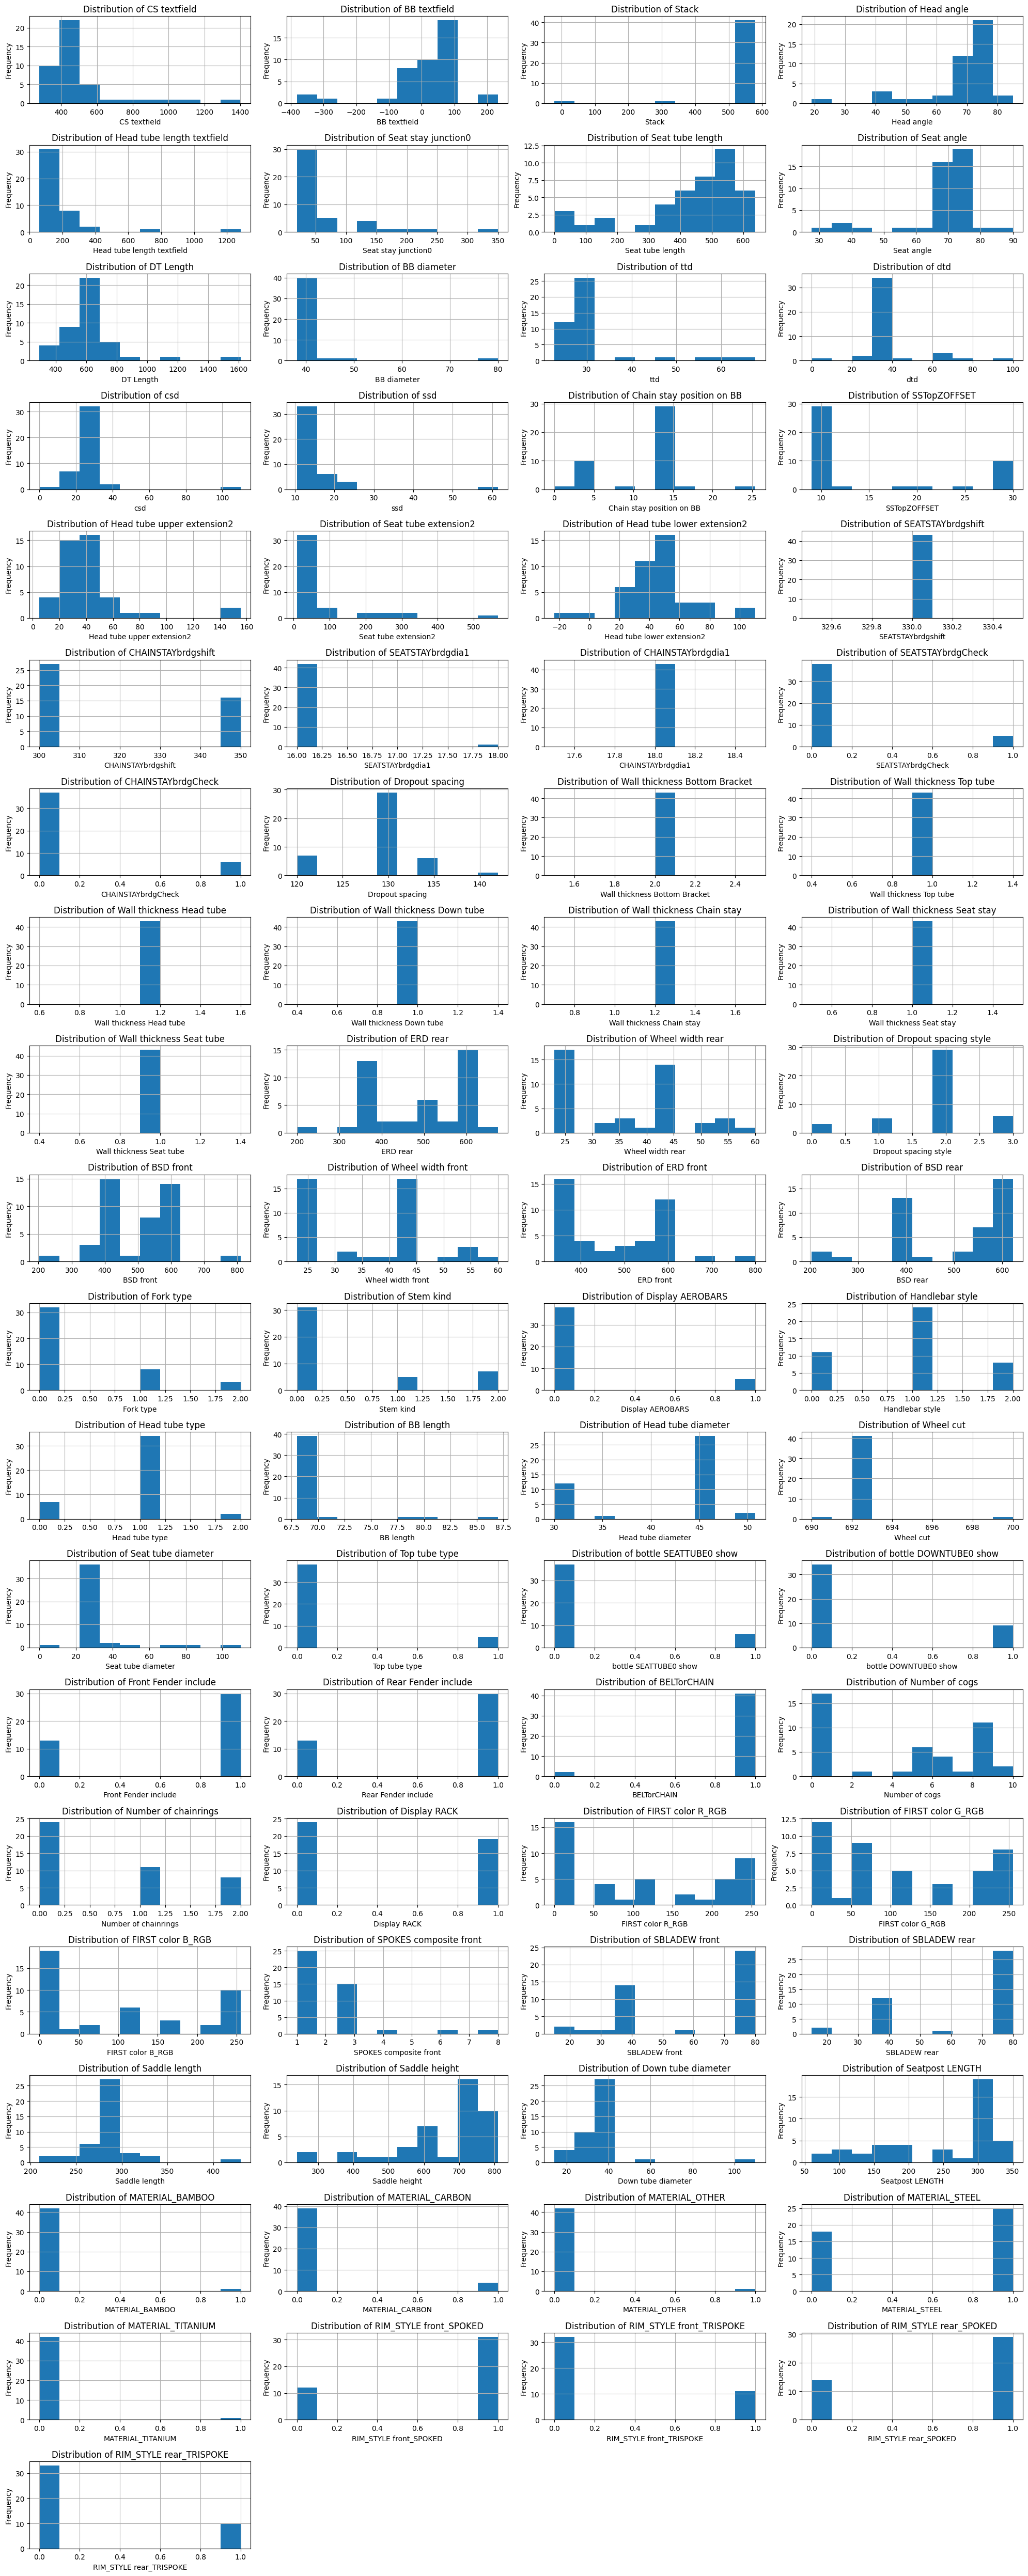

In [22]:
# Create a grid of subplots

num_rows = 20  # Number of rows in the grid
num_cols = 4   # Number of columns in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature and plot its distribution
for i, feat in enumerate(feature_df.columns):
    ax = axes[i]  # Select the current subplot
    feature_df[feat].plot(kind='hist', bins=10, ax=ax)  # Plot histogram for the current feature
    ax.set_title(f'Distribution of {feat}')  # Set title
    ax.set_xlabel(feat)  # Set x-axis label
    ax.set_ylabel('Frequency')  # Set y-axis label
    ax.grid(True)  # Show grid

# Hide any extra subplots
for i in range(len(feature_df.columns), num_rows*num_cols):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [23]:
#REMOVE DUPLICATED
duplicate_columns = {}
seen_columns = {}
def get_duplicate_columns(df):
    for column in feature_df.columns:
        current_column = feature_df[column]

        # Convert column data to bytes
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()

        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else: seen_columns[current_column_hash] = column

    return duplicate_columns

#wilson
duplicate_columns = get_duplicate_columns(feature_df)
print("duplicated", duplicate_columns)
for one_list in duplicate_columns.values():
    feature_df.drop(columns=one_list,inplace=True)
    

print(feature_df.shape)

duplicated {'Wall thickness Top tube': ['Wall thickness Down tube', 'Wall thickness Seat tube'], 'Front Fender include': ['Rear Fender include']}
(43, 74)


In [24]:


# Remove (almost) constant features
sel = VarianceThreshold(0.05)
feature_numpy = sel.fit_transform(feature_df)

# Get the indices of the discarded features
discarded_indices = np.where(~sel.get_support())[0]

# Get the column names of the discarded features
discarded_columns = feature_df.columns[discarded_indices]
print("Discarded constant columns:", discarded_columns)

# Get the indices of the selected features
selected_indices = sel.get_support(indices=True)

# Get the column names of the selected features
selected_columns = feature_df.columns[selected_indices]

# Create a DataFrame with only the remaining features
feature_df_new = pd.DataFrame(data=feature_numpy, columns=selected_columns)

# Restore the original indexes
feature_df_new.index = feature_df.index

# Output the shape and head of the remaining features DataFrame
print("Shape of remaining features DataFrame:", feature_df_new.shape)
print("Head of remaining features DataFrame:")


Discarded constant columns: Index(['SEATSTAYbrdgshift', 'CHAINSTAYbrdgdia1',
       'Wall thickness Bottom Bracket', 'Wall thickness Top tube',
       'Wall thickness Head tube', 'Wall thickness Chain stay',
       'Wall thickness Seat stay', 'BELTorCHAIN', 'MATERIAL_BAMBOO',
       'MATERIAL_OTHER', 'MATERIAL_TITANIUM'],
      dtype='object')
Shape of remaining features DataFrame: (43, 63)
Head of remaining features DataFrame:


In [99]:
print(len(discarded_columns))

11


In [25]:
corr_matrix = feature_df_new.corr("spearman")
# Get the column names of the DataFrame
columns = corr_matrix.columns

# Create an empty list to keep track of columns to drop
columns_to_drop = []

# Loop over the columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        # Access the cell of the DataFrame
        if corr_matrix.loc[columns[i], columns[j]] > 0.95:
            columns_to_drop.append(columns[j])

print(columns_to_drop)
feature_df_new.drop(columns = columns_to_drop, axis = 1, inplace=True)


['Wheel width front']


In [26]:

feature_df_new.shape

(43, 62)

In [27]:


spearman = {}

# Iterate over unique_cat_names
for cat in unique_cat_names:
    print(cat)
    # Compute Spearman correlation coefficients and p-values for features in remaining_features_df and target variable in wilson_df
    rho_corr_pval = [(feature, stats.spearmanr(feature_df_new[feature], wilson_df[cat+"_wilson"])) for feature in feature_df_new.columns]
    
    # Filter significant correlations with p-value < 0.05
    significant_correlations = [(feature, correlation.correlation, correlation.pvalue) for feature, correlation in rho_corr_pval if correlation.pvalue < 0.05]
    
    # Sort the significant correlations by absolute value of correlation coefficient in descending order
    significant_correlations_sorted = sorted(significant_correlations, key=lambda x: abs(x[1]), reverse=True)
    print(len(significant_correlations_sorted))
    print(significant_correlations_sorted)
    spearman[cat] = significant_correlations_sorted
    
    

minimalism
10
[('Number of chainrings', -0.4151614488543928, 0.005634300974539565), ('FIRST color B_RGB', 0.4149409591647294, 0.005662350647871833), ('ERD rear', -0.3736976667090449, 0.013569914355795827), ('bottle DOWNTUBE0 show', -0.3693362740992313, 0.014793215653322377), ('bottle SEATTUBE0 show', -0.3658642504586535, 0.015832789914822506), ('Front Fender include', -0.36191256146105066, 0.017090593422883996), ('Number of cogs', -0.35499232755840066, 0.019496655621283637), ('CHAINSTAYbrdgshift', 0.3458126079709874, 0.023122379389371495), ('SSTopZOFFSET', -0.3204829201000241, 0.036149743616152745), ('Saddle height', -0.31564335929834153, 0.039220997184677385)]
elegance
9
[('BSD front', 0.3826269052074192, 0.011331719929601544), ('CHAINSTAYbrdgshift', 0.3737917265906458, 0.013544509966091479), ('ERD front', 0.33099159550959173, 0.030157121970674966), ('Handlebar style', -0.329905237250532, 0.030735765498329733), ('Seatpost LENGTH', 0.3283282879289683, 0.03159202462427964), ('ssd', -0.3

3
[('Head angle', -0.45255750576496495, 0.002311184769808412), ('Stack', -0.3323494399066016, 0.02944657345933037), ('CS textfield', 0.3012432472026425, 0.04964128471625578)]
uniqueness
5
[('Head angle', -0.3569463408863298, 0.018790053061665854), ('Handlebar style', 0.3365492089692049, 0.02733608245947255), ('Seat tube length', -0.3219750192996252, 0.035243667780059176), ('Front Fender include', 0.3102777205848198, 0.042872098867965745), ('Chain stay position on BB', -0.3061811847979196, 0.045841955025441555)]


In [28]:
mw = {}

df = pd.concat([feature_df_new, binary_df.iloc[:,-6:]], axis=1)
for c in unique_cat_names:
    important_feat = []
    print("\n", c)
    for feature in feature_df_new.columns:
        class_1 =  df[df[c +'_binary'] == 1][feature].values
        class_0 =  df[df[c +'_binary'] == 0][feature].values

        # Perform Mann-Whitney U test
        U_statistic, p_value = mannwhitneyu(class_1, class_0)
        if p_value < 0.05:
            important_feat.append((feature, p_value))

            print("\n Significant difference found.")
            print(f"Feature: {feature}")
            print(f"P-Value: {p_value}")
    
    mw[c] = important_feat



 minimalism

 Significant difference found.
Feature: ERD rear
P-Value: 0.01547604225100044

 Significant difference found.
Feature: BSD rear
P-Value: 0.03911405527431676

 Significant difference found.
Feature: bottle SEATTUBE0 show
P-Value: 0.020495301405510043

 Significant difference found.
Feature: Number of chainrings
P-Value: 0.0306447237259767

 Significant difference found.
Feature: Saddle height
P-Value: 0.0052955948261018074

 elegance

 Significant difference found.
Feature: BB textfield
P-Value: 0.01948319451486034

 Significant difference found.
Feature: Seat tube length
P-Value: 0.02538263671216512

 Significant difference found.
Feature: BSD front
P-Value: 0.025979267507587722

 Significant difference found.
Feature: ERD front
P-Value: 0.031155581170254236

 Significant difference found.
Feature: BSD rear
P-Value: 0.04628649516163598

 aesthetics

 Significant difference found.
Feature: Seat tube length
P-Value: 0.017827825058212263

 Significant difference found.
Featu

minimalism
elegance
aesthetics
usability
innovation
uniqueness


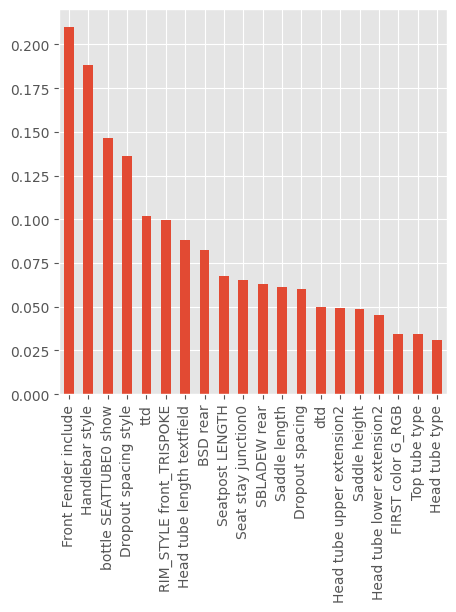

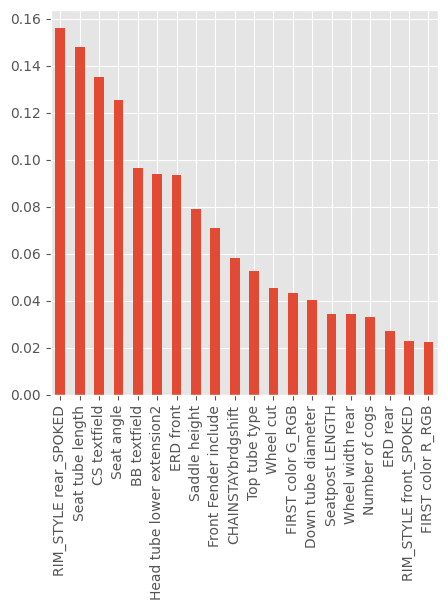

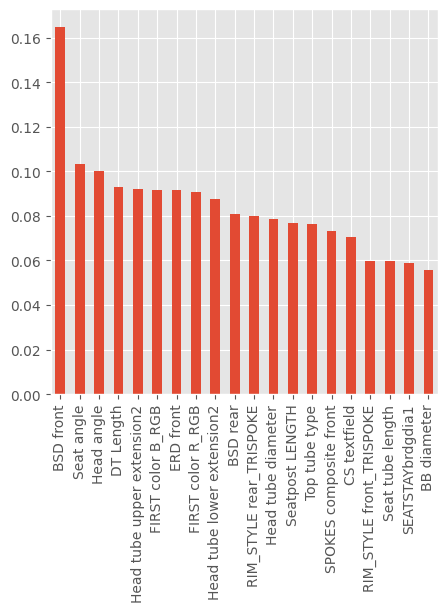

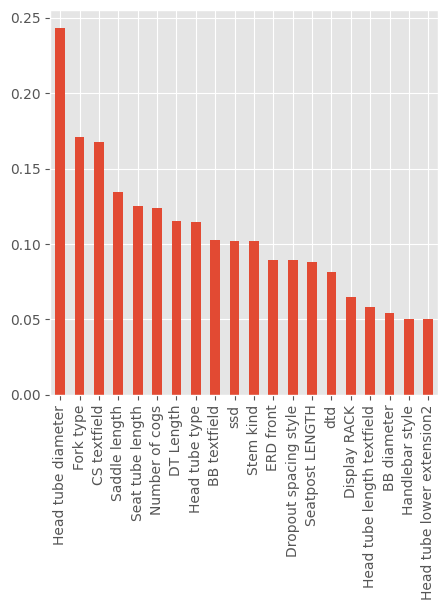

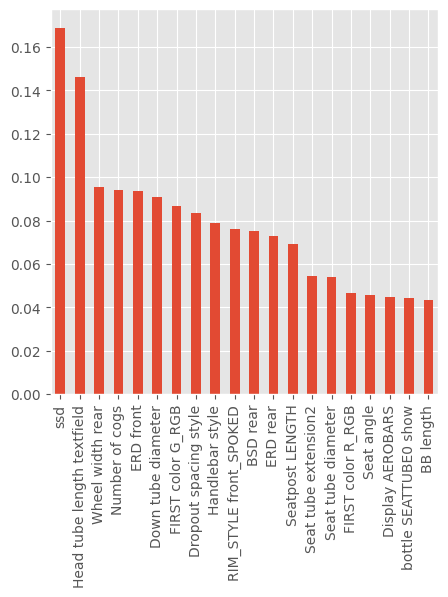

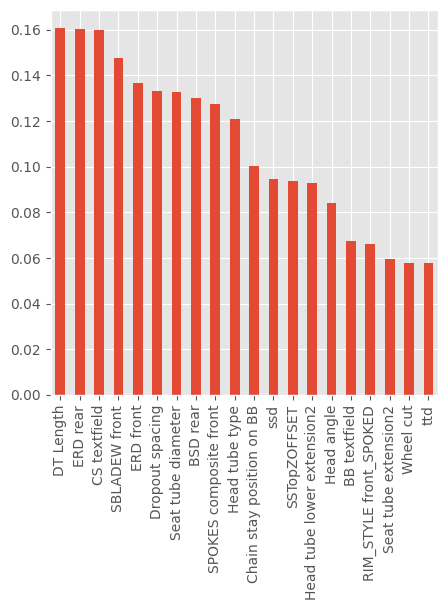

In [101]:

mi_binary = {}
for cat in unique_cat_names:
    print(cat)
    mi=mutual_info_classif(feature_df_new, binary_df[cat+"_binary"])
    series=pd.Series(mi,index=feature_df_new.columns).sort_values(ascending=False)
    top_20_features = series.head(20)
    # Store the top 10 features in the dictionary
    mi_binary[cat] = top_20_features
    
   
    plt.figure(figsize=(5,5))
    plt.style.use('ggplot')
    series.head(20).plot(kind='bar')
    #plt.show()

minimalism
elegance
aesthetics
usability
innovation
uniqueness


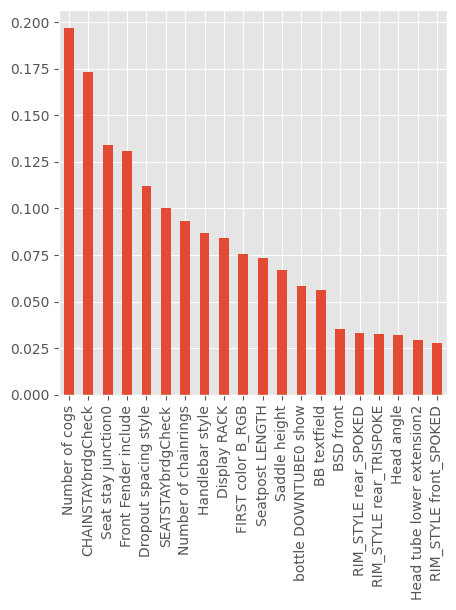

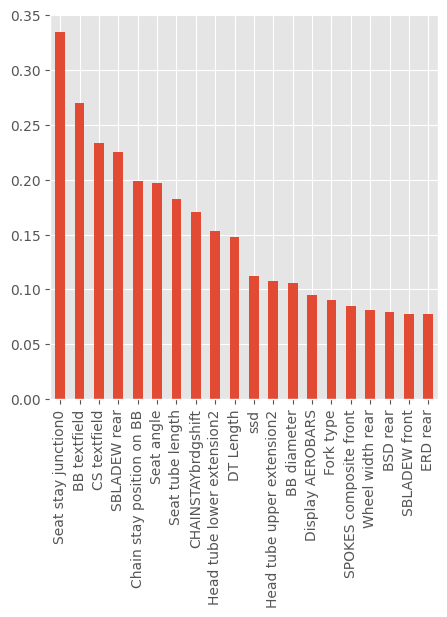

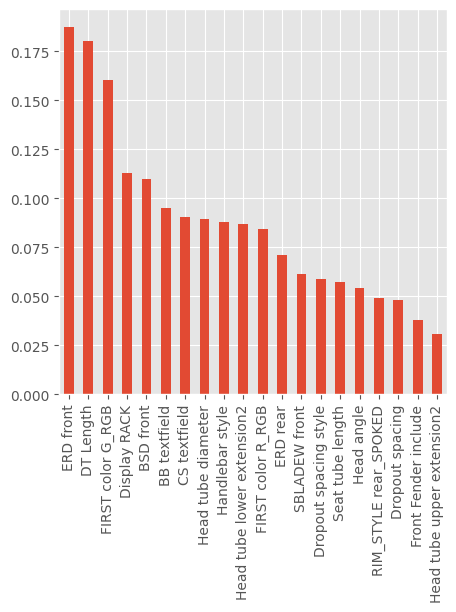

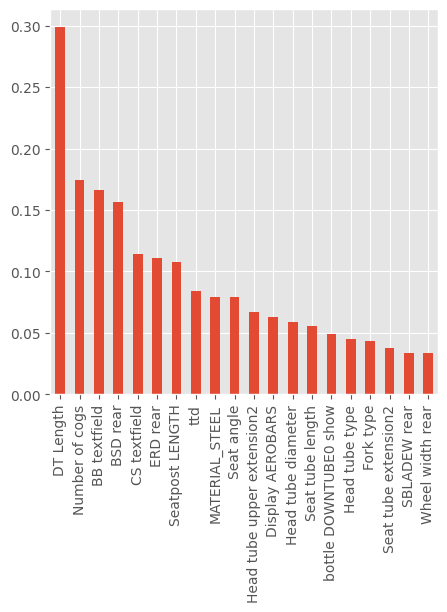

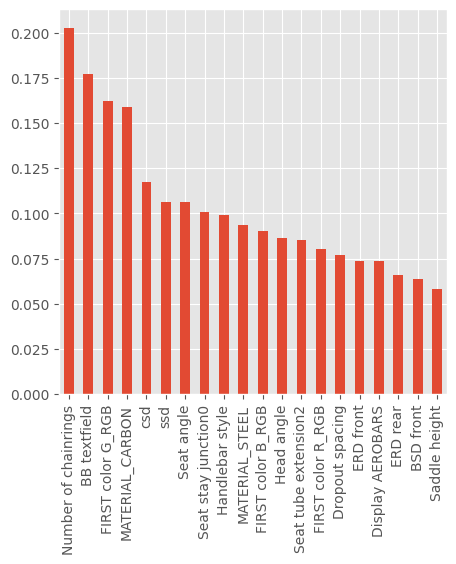

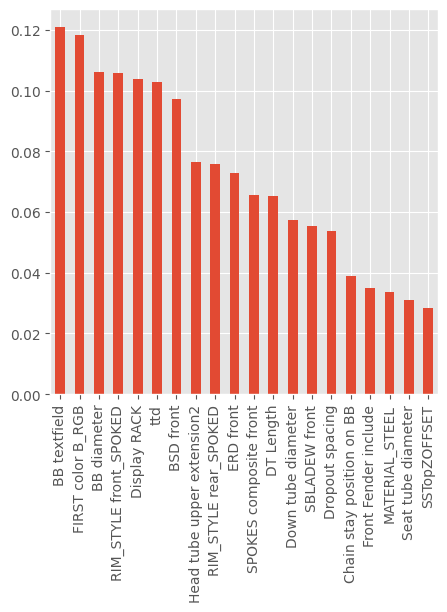

In [100]:

mi_wilson = {}
for cat in unique_cat_names:
    print(cat)
    mi=mutual_info_regression(feature_df_new, wilson_df[cat+"_wilson"])
    series=pd.Series(mi,index=feature_df_new.columns).sort_values(ascending=False)
    top_20_features = series.head(20)
    mi_wilson[cat] = top_20_features
    plt.figure(figsize=(5,5))
    plt.style.use('ggplot')
    series.head(20).plot(kind='bar')
    #plt.show()

In [31]:

#scale data
# Scale data
scaler = preprocessing.StandardScaler().fit(feature_df_new)
X_scaled = scaler.transform(feature_df_new)
# Convert scaled array back to DataFrame with the same indexes
X = pd.DataFrame(data=X_scaled, columns=feature_df_new.columns, index=feature_df_new.index)


LOGISTIC REGRESSION (BINARY)

In [32]:

rfecv_logreg_binary = {}

for c in unique_cat_names:
    print(c)
    min_features_to_select = 1  # Minimum number of features to consider
    clf = LogisticRegression(penalty='l1',  solver='saga', max_iter=10000)
    cv = StratifiedKFold(5)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
    )
    rfecv.fit(X, binary_df[c+'_binary'])
    selected_features = X.columns[rfecv.get_support()]
    print("Selected features:")
    print(selected_features)
    rfecv_logreg_binary[c] = selected_features
    print(f"Optimal number of features: {rfecv.n_features_}")
   
   

minimalism
Selected features:
Index(['CS textfield', 'SSTopZOFFSET', 'Head tube lower extension2',
       'ERD rear', 'bottle SEATTUBE0 show'],
      dtype='object')
Optimal number of features: 5
elegance
Selected features:
Index(['CS textfield', 'Chain stay position on BB', 'CHAINSTAYbrdgshift',
       'ERD front', 'Saddle height', 'MATERIAL_STEEL'],
      dtype='object')
Optimal number of features: 6
aesthetics
Selected features:
Index(['CS textfield'], dtype='object')
Optimal number of features: 1
usability
Selected features:
Index(['Head angle', 'Chain stay position on BB', 'CHAINSTAYbrdgCheck',
       'Wheel width rear', 'Dropout spacing style', 'Fork type',
       'Display AEROBARS', 'Handlebar style', 'Wheel cut', 'Saddle height',
       'Seatpost LENGTH', 'MATERIAL_CARBON'],
      dtype='object')
Optimal number of features: 12
innovation
Selected features:
Index(['Head angle', 'Chain stay position on BB', 'Display AEROBARS'], dtype='object')
Optimal number of features: 3
unique

LINEAR REGRESSION (WILSON)

In [33]:


rfecv_linear_wilson = {}
for c in unique_cat_names:
    print(c)
    min_features_to_select = 1  # Minimum number of features to consider
    clf = LinearRegression()  # Use LinearRegression for regression tasks
    cv = KFold(n_splits=5)  # Use KFold for regression tasks

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="neg_mean_squared_error",  # Use appropriate scoring metric for regression
        min_features_to_select=min_features_to_select,
        n_jobs=2,
    )
    rfecv.fit(X, wilson_df[c+'_wilson'])  # Adjust target variable

    selected_features = X.columns[rfecv.get_support()]
    print("Selected features:")
    print(selected_features)
    rfecv_linear_wilson[c] = selected_features
    print(f"Optimal number of features: {rfecv.n_features_}")


minimalism
Selected features:
Index(['Number of chainrings'], dtype='object')
Optimal number of features: 1
elegance
Selected features:
Index(['BB textfield'], dtype='object')
Optimal number of features: 1
aesthetics
Selected features:
Index(['Head angle', 'Seat tube length'], dtype='object')
Optimal number of features: 2
usability
Selected features:
Index(['BSD rear'], dtype='object')
Optimal number of features: 1
innovation
Selected features:
Index(['DT Length'], dtype='object')
Optimal number of features: 1
uniqueness
Selected features:
Index(['CS textfield', 'BB textfield', 'Stack', 'Head angle',
       'Head tube length textfield', 'Seat stay junction0', 'Seat tube length',
       'DT Length', 'BB diameter', 'ttd', 'dtd', 'ssd',
       'Chain stay position on BB', 'SSTopZOFFSET',
       'Head tube upper extension2', 'Seat tube extension2',
       'Head tube lower extension2', 'CHAINSTAYbrdgshift', 'SEATSTAYbrdgdia1',
       'SEATSTAYbrdgCheck', 'CHAINSTAYbrdgCheck', 'ERD rear', 'B

RANDOM FOREST CLASSIFIER (binary)

In [34]:


rfecv_rf_binary = {}

for c in unique_cat_names:
    print(c)
    min_features_to_select = 1  # Minimum number of features to consider
    clf = RandomForestClassifier(random_state=42, **params)
    cv = StratifiedKFold(5)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
    )
    rfecv.fit(X, binary_df[c+'_binary'])
    selected_features = X.columns[rfecv.get_support()]
    print("Selected features:")
    print(selected_features)
    
    rfecv_rf_binary[c] = selected_features
    print(f"Optimal number of features: {rfecv.n_features_}")


minimalism
Selected features:
Index(['CS textfield', 'BB textfield', 'Stack', 'Head angle',
       'Head tube length textfield', 'Seat stay junction0', 'Seat tube length',
       'Seat angle', 'DT Length', 'BB diameter', 'ttd', 'dtd', 'csd', 'ssd',
       'Chain stay position on BB', 'SSTopZOFFSET',
       'Head tube upper extension2', 'Seat tube extension2',
       'Head tube lower extension2', 'CHAINSTAYbrdgshift', 'Dropout spacing',
       'ERD rear', 'Wheel width rear', 'Dropout spacing style', 'ERD front',
       'BSD rear', 'Display AEROBARS', 'Handlebar style', 'Wheel cut',
       'Seat tube diameter', 'bottle SEATTUBE0 show', 'Front Fender include',
       'Number of cogs', 'Number of chainrings', 'FIRST color R_RGB',
       'FIRST color G_RGB', 'FIRST color B_RGB', 'SBLADEW front',
       'SBLADEW rear', 'Saddle length', 'Saddle height', 'Down tube diameter',
       'Seatpost LENGTH', 'RIM_STYLE front_SPOKED', 'RIM_STYLE front_TRISPOKE',
       'RIM_STYLE rear_SPOKED'],
      

RANDOM FOREST REGRESSION (WILSON)

In [35]:

rfecv_rf_wilson = {}
for c in unique_cat_names:
    print(c)
    min_features_to_select = 1  # Minimum number of features to consider
    clf = RandomForestRegressor(random_state=42,**params)  # Use RandomForestRegressor
    cv = KFold(n_splits=5)  # Use KFold for regression tasks

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="neg_mean_squared_error",  # Use appropriate scoring metric for regression
        min_features_to_select=min_features_to_select,
        n_jobs=2,
    )
    rfecv.fit(X, wilson_df[c+'_wilson'])  
    selected_features = X.columns[rfecv.get_support()]
    print("Selected features:")
    print(selected_features)
    rfecv_rf_wilson[c] = selected_features
    print(f"Optimal number of features: {rfecv.n_features_}")


minimalism
Selected features:
Index(['CS textfield', 'BB textfield', 'Head angle',
       'Head tube length textfield', 'Seat stay junction0', 'Seat tube length',
       'Seat angle', 'DT Length', 'dtd', 'csd', 'Head tube upper extension2',
       'Seat tube extension2', 'Head tube lower extension2', 'Dropout spacing',
       'ERD rear', 'Dropout spacing style', 'ERD front', 'BSD rear',
       'Number of cogs', 'Number of chainrings', 'FIRST color R_RGB',
       'FIRST color G_RGB', 'FIRST color B_RGB', 'Saddle height'],
      dtype='object')
Optimal number of features: 24
elegance
Selected features:
Index(['CS textfield', 'BB textfield', 'Stack', 'Head angle',
       'Head tube length textfield', 'Seat stay junction0', 'Seat tube length',
       'Seat angle', 'DT Length', 'BB diameter', 'ttd', 'dtd', 'csd', 'ssd',
       'Chain stay position on BB', 'SSTopZOFFSET',
       'Head tube upper extension2', 'Seat tube extension2',
       'Head tube lower extension2', 'CHAINSTAYbrdgshift', '

In [36]:

featsel_binary = {}

for cat in unique_cat_names:
    print(cat)
    
    # Create a selector for the current category
    sel = SelectByTargetMeanPerformance(
        variables=None,
        scoring="accuracy",
        bins=2,
        strategy="equal_frequency",
        cv=5,  # cross validation
    )
    
    # Fit the selector with the target variable corresponding to the current category
    sel.fit(X, binary_df[cat + '_binary'])
    print(len(X.columns))
    print("dropped", len(sel.features_to_drop_), sel.features_to_drop_)
    print("remaining", len(list(set(sel.variables_) - set(sel.features_to_drop_))))
    featsel_binary[cat] = list(set(sel.variables_) - set(sel.features_to_drop_))



minimalism
62
dropped 19 ['CS textfield', 'BB textfield', 'Head angle', 'Head tube length textfield', 'Seat tube length', 'DT Length', 'dtd', 'csd', 'ssd', 'Chain stay position on BB', 'Dropout spacing', 'BSD front', 'ERD front', 'Head tube diameter', 'Seat tube diameter', 'Number of cogs', 'FIRST color B_RGB', 'Saddle length', 'Down tube diameter']
remaining 43
elegance
62
dropped 41 ['Stack', 'Head tube length textfield', 'Seat stay junction0', 'BB diameter', 'Chain stay position on BB', 'SSTopZOFFSET', 'Head tube upper extension2', 'Seat tube extension2', 'Head tube lower extension2', 'CHAINSTAYbrdgshift', 'SEATSTAYbrdgdia1', 'SEATSTAYbrdgCheck', 'CHAINSTAYbrdgCheck', 'Dropout spacing', 'Dropout spacing style', 'Fork type', 'Stem kind', 'Display AEROBARS', 'Handlebar style', 'Head tube type', 'BB length', 'Wheel cut', 'Seat tube diameter', 'Top tube type', 'bottle SEATTUBE0 show', 'bottle DOWNTUBE0 show', 'Front Fender include', 'Number of chainrings', 'Display RACK', 'FIRST color G

In [37]:
from feature_engine.selection import SelectByTargetMeanPerformance
featsel_wilson = {}
for cat in unique_cat_names:
    print(cat)
    
    # Create a selector for the current category
    sel = SelectByTargetMeanPerformance(
        variables=None,
        regression = True,
        scoring="r2",
        bins=2,
        strategy="equal_frequency",
        cv=5,  # cross validation
    )
    
    # Fit the selector with the target variable corresponding to the current category
    sel.fit(X, wilson_df[cat + '_wilson'])
    # Print selected features and features to drop for the current category
    #print(len(sel.feature_performance_), sel.feature_performance_)
    print(len(X.columns))
    print("dropped", len(sel.features_to_drop_), sel.features_to_drop_)
    print("remaining", len(list(set(sel.variables_) - set(sel.features_to_drop_))))
    featsel_wilson[cat] = list(set(sel.variables_) - set(sel.features_to_drop_))


minimalism
62
dropped 20 ['CS textfield', 'BB textfield', 'Seat stay junction0', 'Seat angle', 'DT Length', 'BB diameter', 'ttd', 'dtd', 'Chain stay position on BB', 'Head tube lower extension2', 'ERD rear', 'Dropout spacing style', 'BSD rear', 'Handlebar style', 'Head tube type', 'Number of cogs', 'FIRST color R_RGB', 'FIRST color G_RGB', 'Down tube diameter', 'Seatpost LENGTH']
remaining 42
elegance
62
dropped 20 ['Head tube length textfield', 'Seat stay junction0', 'Seat angle', 'DT Length', 'ttd', 'Head tube upper extension2', 'Seat tube extension2', 'Head tube lower extension2', 'Dropout spacing', 'ERD rear', 'Dropout spacing style', 'Handlebar style', 'Head tube type', 'Seat tube diameter', 'Number of cogs', 'FIRST color R_RGB', 'FIRST color G_RGB', 'SBLADEW front', 'Saddle length', 'Down tube diameter']
remaining 42
aesthetics
62
dropped 45 ['CS textfield', 'Stack', 'Head angle', 'Seat stay junction0', 'BB diameter', 'ttd', 'dtd', 'csd', 'ssd', 'SSTopZOFFSET', 'Head tube upper e

In [38]:

for val in featsel_binary.values():
    print(len(val))

43
21
19
20
40
22


In [39]:

for val in featsel_wilson.values():
    print(len(val))

42
42
17
41
42
44


PUT TOGETHER FEATURES SELECTED BY VARIOUS METHOD TO COMPARE WITH BASELINE MODEL

In [91]:
#take out feature names
all_binary = [mw, mi_binary, rfecv_logreg_binary, rfecv_rf_binary, featsel_binary]
all_names_binary = {}
for c in unique_cat_names:
    all_names_b = []
    for i, one in enumerate(all_binary):
        if c in one:
            if isinstance(one[c], list):
                if  all(isinstance(item, tuple) for item in one[c]):
                    names = [tup[0] for tup in one[c]]
                    all_names_b.append(names)
                else: 
                    all_names_b.extend(one[c])
            elif isinstance(one[c], pd.Index):
                names =  one[c].tolist()
                all_names_b.append(names)
            else:
                names = one[c].index.tolist()   
                all_names_b.append(names)
           # Flatten the list of lists
            flat_list = [item for sublist in all_names_b for item in (sublist if isinstance(sublist, list) else [sublist])]
            all_names_binary[c] = flat_list
        else:
            print("no key here", i)

features_final_binary = {}
for key, value in all_names_binary.items():
    features_final_binary[key] = []
    # Count occurrences of each element in the list
    element_counts = {element: value.count(element) for element in value}
    #append those with count more than 1
    print(element_counts)
    for element, count in element_counts.items():
        if count > 2:
            features_final_binary[key].append(str(element))




{'ERD rear': 4, 'BSD rear': 4, 'bottle SEATTUBE0 show': 5, 'Number of chainrings': 3, 'Saddle height': 4, 'Dropout spacing style': 3, 'RIM_STYLE rear_SPOKED': 3, 'Head tube length textfield': 2, 'Number of cogs': 2, 'Dropout spacing': 2, 'MATERIAL_CARBON': 2, 'Fork type': 2, 'Seatpost LENGTH': 3, 'Top tube type': 2, 'dtd': 2, 'Front Fender include': 3, 'Saddle length': 2, 'RIM_STYLE front_SPOKED': 3, 'FIRST color B_RGB': 2, 'SEATSTAYbrdgCheck': 2, 'Head tube upper extension2': 3, 'RIM_STYLE rear_TRISPOKE': 2, 'CS textfield': 2, 'SSTopZOFFSET': 3, 'Head tube lower extension2': 3, 'BB textfield': 1, 'Stack': 2, 'Head angle': 1, 'Seat stay junction0': 2, 'Seat tube length': 1, 'Seat angle': 2, 'DT Length': 1, 'BB diameter': 2, 'ttd': 2, 'csd': 1, 'ssd': 1, 'Chain stay position on BB': 1, 'Seat tube extension2': 2, 'CHAINSTAYbrdgshift': 2, 'Wheel width rear': 2, 'ERD front': 1, 'Display AEROBARS': 2, 'Handlebar style': 2, 'Wheel cut': 2, 'Seat tube diameter': 1, 'FIRST color R_RGB': 2, 'FI

In [92]:
#take out feature names

all_wilson = [spearman, mi_wilson, rfecv_linear_wilson, rfecv_rf_wilson, featsel_wilson]
all_names_wilson = {}
for c in unique_cat_names:
    all_names = []
    for i, one in enumerate(all_wilson):
        if c in one:
            if isinstance(one[c], list):
                if  all(isinstance(item, tuple) for item in one[c]):
                    names = [tup[0] for tup in one[c]]
                    all_names.append(names)
                else: 
                    all_names.extend(one[c])
            elif isinstance(one[c], pd.Index):
                names =  one[c].tolist()
                all_names.append(names)
            else:
                names = one[c].index.tolist()
                all_names.append(names)
            # Flatten the list of lists
            flat_list = [item for sublist in all_names for item in (sublist if isinstance(sublist, list) else [sublist])]
            all_names_wilson[c] = flat_list
        else:
            print("there is no key here!", i)


features_final_wilson = {}
for key, value in all_names_wilson.items():
    print(key)
    features_final_wilson[key] = []
    # Count occurrences of each element in the list
    element_counts = {element: value.count(element) for element in value}
    #append those with count > 1
    print(element_counts)
    for element, count in element_counts.items():
        if count > 2:
            features_final_wilson[key].append(str(element))




minimalism
{'Number of chainrings': 4, 'FIRST color B_RGB': 4, 'ERD rear': 2, 'bottle DOWNTUBE0 show': 3, 'bottle SEATTUBE0 show': 2, 'Front Fender include': 3, 'Number of cogs': 3, 'CHAINSTAYbrdgshift': 2, 'SSTopZOFFSET': 2, 'Saddle height': 4, 'Dropout spacing': 3, 'CHAINSTAYbrdgCheck': 2, 'Seatpost LENGTH': 1, 'SEATSTAYbrdgdia1': 2, 'SEATSTAYbrdgCheck': 2, 'Handlebar style': 1, 'Seat stay junction0': 2, 'Dropout spacing style': 2, 'Display RACK': 2, 'BB textfield': 2, 'RIM_STYLE rear_SPOKED': 2, 'Stack': 2, 'BB length': 2, 'Wheel cut': 2, 'RIM_STYLE front_SPOKED': 2, 'CS textfield': 1, 'Head angle': 2, 'Head tube length textfield': 2, 'Seat tube length': 2, 'Seat angle': 1, 'DT Length': 1, 'dtd': 1, 'csd': 2, 'Head tube upper extension2': 2, 'Seat tube extension2': 2, 'Head tube lower extension2': 1, 'ERD front': 2, 'BSD rear': 1, 'FIRST color R_RGB': 1, 'FIRST color G_RGB': 1, 'MATERIAL_CARBON': 1, 'RIM_STYLE rear_TRISPOKE': 1, 'RIM_STYLE front_TRISPOKE': 1, 'Display AEROBARS': 1, 

COMPARE TO BASELINE

In [107]:
features_final_binary

{'minimalism': ['ERD rear',
  'BSD rear',
  'bottle SEATTUBE0 show',
  'Number of chainrings',
  'Saddle height',
  'Dropout spacing style',
  'RIM_STYLE rear_SPOKED',
  'Seatpost LENGTH',
  'Front Fender include',
  'RIM_STYLE front_SPOKED',
  'Head tube upper extension2',
  'SSTopZOFFSET',
  'Head tube lower extension2'],
 'elegance': ['BB textfield',
  'Seat tube length',
  'BSD front',
  'ERD front',
  'CS textfield',
  'Saddle height',
  'ssd'],
 'aesthetics': ['Seat tube length',
  'BSD front',
  'ERD front',
  'CS textfield',
  'DT Length',
  'FIRST color B_RGB',
  'Head angle'],
 'usability': ['Seat tube length',
  'DT Length',
  'Dropout spacing style',
  'Display AEROBARS',
  'Handlebar style',
  'BB textfield',
  'Head tube length textfield'],
 'innovation': ['Chain stay position on BB',
  'Display AEROBARS',
  'Head tube length textfield'],
 'uniqueness': ['Chain stay position on BB',
  'Handlebar style',
  'ERD front',
  'Seat tube diameter',
  'CS textfield',
  'Head tube

In [ ]:
features_final_wilson


LOGISTIC REGRESSION (BINARY)

In [93]:


# Define the number of folds for cross-validation
n_folds = 5  # Adjust as needed

for c in unique_cat_names:
    print(c)
    # Only keep features selected by more than 1 method
    cols = feature_df_new[features_final_binary[c]]
    scaler = preprocessing.StandardScaler().fit(cols)
    cols_scaled = scaler.transform(cols)
    # Convert scaled array back to DataFrame with the same indexes
    X = pd.DataFrame(data=cols_scaled, columns=cols.columns, index=cols.index)
    print("number features used:", len(X.columns))
    y = binary_df[c + '_binary']

    ################################
    reg = LogisticRegression(max_iter=10000).fit(X, y)
    print("score logistic regression no cv no penalty:", reg.score(X, y))

    ################################
    reg = LogisticRegression(penalty='l1',  solver='saga', max_iter=10000).fit(X, y)
    print("score lasso no cv yes penalty:", reg.score(X, y))

    ########################################

    reg = LogisticRegression(penalty='l1',  solver='saga', max_iter=10000)

    # Perform cross-validation for accuracy
    cv_acc_scores = cross_val_score(reg, X, y, cv=kf, scoring='accuracy')

    # Perform cross-validation for F1 score
    cv_f1_scores = cross_val_score(reg, X, y, cv=kf, scoring='f1')

    # Compute overall accuracy score
    print(cv_acc_scores)
    overall_acc = np.mean(cv_acc_scores)

    # Compute overall F1 score
    overall_f1 = np.mean(cv_f1_scores)

    print("logistic regression with cv + penalty average accuracy:", overall_acc)
    print("logistic regression with cv + penalty average F1 score:", overall_f1)
    print("\n")


minimalism
number features used: 13
score logistic regression no cv no penalty: 0.8837209302325582
score lasso no cv yes penalty: 0.9069767441860465
[0.66666667 0.66666667 0.55555556 0.875      0.5       ]
logistic regression with cv + penalty average accuracy: 0.6527777777777778
logistic regression with cv + penalty average F1 score: 0.7353535353535353


elegance
number features used: 7
score logistic regression no cv no penalty: 0.6976744186046512
score lasso no cv yes penalty: 0.6744186046511628
[0.66666667 0.22222222 0.77777778 0.5        0.5       ]
logistic regression with cv + penalty average accuracy: 0.5333333333333333
logistic regression with cv + penalty average F1 score: 0.5698989898989899


aesthetics
number features used: 7
score logistic regression no cv no penalty: 0.8372093023255814
score lasso no cv yes penalty: 0.8604651162790697
[0.66666667 0.66666667 0.88888889 0.625      0.875     ]
logistic regression with cv + penalty average accuracy: 0.7444444444444445
logisti

RANDOM FOREST (BINARY)

In [94]:


# Define the Random Forest regressor
rf_class = RandomForestClassifier(**params)

for c in unique_cat_names:
    print(c)
    #only keep features selected by more than 1 method
    cols = feature_df_new[features_final_binary[c]]
    scaler = preprocessing.StandardScaler().fit(cols)
    cols_scaled = scaler.transform(cols)
    # Convert scaled array back to DataFrame with the same indexes
    X = pd.DataFrame(data=cols_scaled, columns=cols.columns, index=cols.index)
    print("number features used:", len(X.columns))
    y = binary_df[c + '_binary']

    ################################
    rf = RandomForestClassifier(**params).fit(X, y)
    print("score rf no cv", rf.score(X, y))

    # Perform cross-validation
    cv_scores = cross_val_score(rf_class, X, y, cv=5, scoring='accuracy')
    # Compute the average R-squared score
    average_acc = np.mean(cv_scores)
    print("Average accuracy score:", average_acc)
    # Perform cross-validation for F1 score
    cv_scores_f1 = cross_val_score(rf_class, X, y, cv=5, scoring='f1')
    # Compute the average F1 score
    average_f1 = np.mean(cv_scores_f1)
    print("Average F1 score:", average_f1)
    print("\n")


minimalism
number features used: 13


score rf no cv 1.0
Average accuracy score: 0.6527777777777778
Average F1 score: 0.7435497835497835


elegance
number features used: 7
score rf no cv 0.9767441860465116
Average accuracy score: 0.6277777777777778
Average F1 score: 0.6266666666666667


aesthetics
number features used: 7
score rf no cv 0.9767441860465116
Average accuracy score: 0.6972222222222222
Average F1 score: 0.6755555555555555


usability
number features used: 7
score rf no cv 1.0
Average accuracy score: 0.7138888888888889
Average F1 score: 0.7523310023310023


innovation
number features used: 3
score rf no cv 0.9302325581395349
Average accuracy score: 0.625
Average F1 score: 0.5793006993006993


uniqueness
number features used: 7
score rf no cv 1.0
Average accuracy score: 0.7194444444444444
Average F1 score: 0.6330735930735931




LASSO (WILSON)

In [95]:

# Define the number of folds for cross-validation
n_folds = 5  # Adjust as needed

for c in unique_cat_names:
    print(c)
    # Only keep features selected by more than 1 method
    cols = feature_df_new[features_final_wilson[c]]
    scaler = preprocessing.StandardScaler().fit(cols)
    cols_scaled = scaler.transform(cols)
    # Convert scaled array back to DataFrame with the same indexes
    X = pd.DataFrame(data=cols_scaled, columns=cols.columns, index=cols.index)
    print("number features used:", len(X.columns))
    y = wilson_df[c + '_wilson']
    
    ################################
    reg = LinearRegression().fit(X, y)
    print("score linear regression no cv:", reg.score(X, y))

    ################################
    reg = Lasso().fit(X, y)
    print("score lasso no cv:", reg.score(X, y))

    ########################################

    # Define the number of folds for cross-validation
    n_folds = 5  # Adjust as needed

    # Initialize Lasso regression model
    reg = Lasso()

    # Perform cross-validation for R-squared score
    cv_r2_scores = cross_val_score(reg, X, y, cv=kf, scoring='r2')
    overall_r_squared = np.mean(cv_r2_scores)

    # Perform cross-validation for MSE
    cv_mse_scores = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_squared_error')
    overall_mse = -np.mean(cv_mse_scores)

    print("lasso with cv average score:", overall_r_squared)
    print("lasso with cv average mse:", overall_mse)
    print("\n")


minimalism
number features used: 7
score linear regression no cv: 0.47176068575872177
score lasso no cv: 0.0
lasso with cv average score: -0.05128889047069909
lasso with cv average mse: 0.023095426491427772


elegance
number features used: 15
score linear regression no cv: 0.5210598883923818
score lasso no cv: 0.0
lasso with cv average score: -0.543982062896488
lasso with cv average mse: 0.019320696843726434


aesthetics
number features used: 8
score linear regression no cv: 0.6257045609776453
score lasso no cv: 0.0
lasso with cv average score: -0.2800058231974548
lasso with cv average mse: 0.02287737888252131


usability
number features used: 8
score linear regression no cv: 0.5036576132722155
score lasso no cv: 0.0
lasso with cv average score: -0.19346961901341006
lasso with cv average mse: 0.03406320219196533


innovation
number features used: 6
score linear regression no cv: 0.25673292908101575
score lasso no cv: 0.0
lasso with cv average score: -0.044754340743237496
lasso with cv 

RANDOM FOREST (WILSON)

In [96]:


# Define the Random Forest regressor
rf_regressor = RandomForestRegressor(**params)
for c in unique_cat_names:
    print(c)
    #only keep features selected by more than 1 method
    cols = feature_df_new[features_final_wilson[c]]
    scaler = preprocessing.StandardScaler().fit(cols)
    cols_scaled = scaler.transform(cols)
    # Convert scaled array back to DataFrame with the same indexes
    X = pd.DataFrame(data=cols_scaled, columns=cols.columns, index=cols.index)
    print("number features used:", len(X.columns))
    y = wilson_df[c + '_wilson']

    ################################
    reg = RandomForestRegressor(**params).fit(X, y)
    print("score rf no cv", reg.score(X, y))

    # Perform cross-validation
    cv_scores = cross_val_score(rf_regressor, X, y, cv=5, scoring='r2')
    # Compute the average R-squared score
    average_r2 = np.mean(cv_scores)
    # Perform cross-validation
    cv_mse= cross_val_score(rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    # Compute the average R-squared score
    average_mse = -np.mean(cv_mse)
    print("Average R-squared score:", average_r2)
    print("Average MSE:", average_mse)
   
    print("\n")


minimalism
number features used: 7
score rf no cv 0.8911865228796261
Average R-squared score: -0.01742172573342158
Average MSE: 0.01632090147421702


elegance
number features used: 15
score rf no cv 0.8692022372520675
Average R-squared score: 0.19053916362218143
Average MSE: 0.016194048336332728


aesthetics
number features used: 8
score rf no cv 0.8940806980404981
Average R-squared score: 0.05213064451014628
Average MSE: 0.01867610286662791


usability
number features used: 8
score rf no cv 0.9112103592444635
Average R-squared score: 0.31520068664402096
Average MSE: 0.02130492973957641


innovation
number features used: 6
score rf no cv 0.8924155129715798
Average R-squared score: -0.12092019186595473
Average MSE: 0.009215712091409537


uniqueness
number features used: 42
score rf no cv 0.8766941323839672
Average R-squared score: 0.07719246527852697
Average MSE: 0.02594617904094524


